# Intro to work with chant data

Cantus Index as big source - for CantusCorpus v1.0 also

Structure of data derived from the database:

![Chant cataloguing schema.](img/chant-cataloguing-schema.png)

For structure of Chant and Source records refer to the Development documentation.  
For gaining more knowledge about Gregorian chant data confront the Intro to chant in documentation.  
Intro to structure of Cantus Database data can bring also documentation of [CantusCorpus](https://github.com/DvorakovaA/CantusCorpus) dataset.

In [1]:
import pycantus
import pycantus.data as data

## Load data
Load the full CantusCorpus v1.0 as one of the pycantus available datasets.  
(If data files are not ready, pycantus will download them.)

In [2]:
# Load the full CantusCorpus v1.0 dataset
cantuscorpus = data.load_dataset('cantuscorpus_v1.0', load_editable=True, create_missing_sources=True)

print(f'Number of chants before filtering: {len(cantuscorpus.chants)}')

Loading chants and sources...
Creating missing sources...
0 missing sources created!
Data loaded!
Number of chants before filtering: 888010


Let's check how many chants exactly we got:

In [16]:
n_chants = len(cantuscorpus.chants)
print(f'Number of chants in CantusCorpus v1.0: {n_chants}')

Number of chants in CantusCorpus v1.0: 888010


And what information is available for each of the chants:

In [12]:
print('Data fields in a chant record:')
for field in cantuscorpus.chants[0].header().split(','):
    print(' ', field)

Data fields in a chant record:
  cantus_id
  incipit
  siglum
  srclink
  chantlink
  folio
  db
  sequence
  feast
  genre
  office
  position
  melody_id
  image
  mode
  full_text
  melody
  century


In [13]:
print('Data fields in a source record:')
for field in cantuscorpus.sources[0].header().split(','):
    print(' ', field)

Data fields in a source record:
  title
  siglum
  century
  provenance
  srclink
  numeric_century
  cursus


## Statistics
Here we would like to inspect our dataset a bit.

We know we have catalogued this huge amount of chants, but many of these will be copies of the same repertoire across many manuscripts. So, how many distinct chants do we have in the catalogued repertoire?

This can be done thanks to the essential Cantus ID mechanism. Instances of the same chant across different manuscripts have the same Cantus ID assigned.

In [ ]:
all_cantus_ids = set(chant.cantus_id for chant in cantuscorpus.chants)
print(f'Number of distinct chants (by Cantus ID): {len(all_cantus_ids)}')

Number of distinct chants (by Cantus ID): 53282


So on average, we can expect to see each Cantus ID:

In [17]:
n_chants / len(all_cantus_ids)

16.666228745167224

But of course averages are not terribly informative. What we probably want to really know is the frequency profile of Cantus IDs: how many appear only once, how many appear twice, and how many are on the other hand of the spectrum, appearing tens or even hundreds of times.

In [18]:
cid_frequencies = {}
for chant in cantuscorpus.chants:
    cid = chant.cantus_id
    # If this is the first time we see this cid, initialize its count to zero
    if cid not in cid_frequencies:
        cid_frequencies[cid] = 0
    # '+=' means 'add and modify original'. 
    # It's shorthand for cid_frequencies[cid] = cid_frequencies[cid] + 1
    cid_frequencies[cid] += 1 

**Visualisation.**

Now we know how often each Cantus ID appeared in the dataset, but printing a dictionary of 31,000+ entries is also not helpful. But what we can do is visualise.

For this, the `matplotlib` library is the most widespread and best-documented for Python.

(Generally when you need to pick a library out of several choices that all support the features you require, go for the one that is most widely used. When you encounter some issue, the more users a library has, the more likely it is that someony has already had that issue and got it resolved, either through StackOverflow or some other publicly available forum.)

In [20]:
import matplotlib.pyplot as plt
# This is a magical shortcut for making sure the visualisatons will be plotted nicely directly in the notebook:
%matplotlib inline

Let's just plot the Cantus ID frequencies, sorted from highest to lowest.

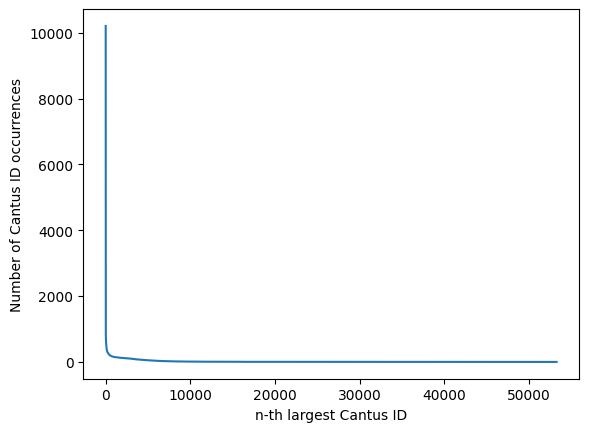

In [21]:
cid_frequencies_sorted = list(sorted(cid_frequencies.values(), reverse=True))  # sorted() by default goes from lowest to highest

plt.plot(cid_frequencies_sorted)
plt.xlabel('n-th largest Cantus ID')   # Best practice: always label both axes.
plt.ylabel('Number of Cantus ID occurrences')
plt.show()

Ok, this is also not very helpful.  
The most frequent Cantus ID occurred more than 10000 times, which makes the rest of the plot rather uninformative.  
  
Let's see the highest-frequency values.

In [23]:
cid_and_frequency_pairs_sorted = list(
    sorted(cid_frequencies.items(),    # The .items() function of a dictionary returns an iterator over all key-value pairs
           reverse=True,               # We still want to go from highest to lowest
           key=lambda kv: kv[1]        # ...so we have to sort by the *value* part of the (key, value) pair.
           )
    )                                  # Finally, we turn the whole thing into a regular list,
                                       # to not have to deal with some Python efficiency magic on sorted() and .items().

In [24]:
# Look at top 10 most frequent Cantus IDs
cid_and_frequency_pairs_sorted[:10]

[('909000', 10207),
 ('g01278', 1221),
 ('008097', 1184),
 ('g01260', 1154),
 ('008414', 1139),
 ('008081', 1090),
 ('001328', 1024),
 ('008201', 1007),
 ('509501', 972),
 ('g00116', 954)]

Ok, `909000` looks like a legitimate Cantus ID. What chant does it represent?

In [25]:
chants_with_909000 = [c for c in cantuscorpus.chants if c.cantus_id == '909000']

In [29]:
chants_with_909000[0].full_text

'Gloria patri et filio et spiritus sancto'

In [36]:
chants_with_909000[2330].full_text

'Gloria patri et filio et spiritui sancto'

In [33]:
chants_with_909000[1000].full_text


'Gloria patri*'

It's the **doxology**!

This is a great example of how the interaction between domain knowledge and computing skills is necessary. These are legitimate chant records: they have all the required information, they have a valid Cantus ID, they record what manuscript they come from, etc. So, those are not mistakes, in the sense in which the empty Cantus ID records were invalid.

What to do? Should we actually treat this as the most frequent Cantus ID? Should it participate in computing the average number of chants per Cantus ID? (Incidentally, the invalid records with no Cantus ID participated in that average as well.)

Here is where domain knowledge comes in. The doxology is the phrase:

_'Gloria Patri et Filii et Spiritui Sancto_

_sicut erat in principio et nunc et semper, et in saecula saeculorum. Amen.'_

which is added at the end of every psalm, and into many other chants, esp. those genres that use psalm verses as their texts. The doxology is not recorded too often, but because it occurs so many times in liturgy, when scribal practices of a certain time and place included recording the doxology as a separate unit (even if just in some contexts), then its frequency skyrockets.

So for the purpose of obtaining useful descriptive statistics, the doxology is not too helpful. Let's exclude it.

We can implement this via filtration exclude values option:

In [37]:
from pycantus.filtration import Filter

In [ ]:
# Prepare a filter that excludes the doxology: Cantus ID 909000
exclude_doxology_filter = Filter('exclude_doxology')

AttributeError: 'Filter' object has no attribute 'add_exclude_value'

## Sources
Fragments vs more complete manuscripts

Monastic vs Secular

### Size

### Origin

## Chants

### Genres
Core ones for Office and for Mass

In [ ]:
GENRES_MASS_PROPERS = ['In', 'InV', 'Gr', 'GrV', 'Al', 'AlV', 'Of', 'OfV', 'Cm', 'CmV', 'Tc', 'TcV']
GENRES_OFFICE = ['A', 'R', 'V', 'W', 'I']

### Feasts
Generally can be divided based on being in Sanctorale or Temporale. Even sources are sometimes divided like that - you cannot expect repertoire for First Sunday of Advent from a Sanctorale maniscript.  

Local feasts can be tricky as they appearance as well as repertoire are influenced by local things, donators, etc.

## Melody
Melodies are encoded in [volpiano]() (not true for neumes but these data are not in CantusCorpus).  
For 

## Known Problems and Troubles
Refer to Harmonization issues in CantusCorpus v1.0 that describes some known troubles of individual data fields.

Overall we can say that the "troubleshooter" is mainly nonunified practice of annotations.  
That means two things:
- annotating something differently (e.g. position of responsories in Matins: *9* vs *3.3*)
- not annotating something (typical for sources fields, overview is provided in CantusCorpus v1.0 README)

Also there are differences between sources from different times, specifically "older", "middle mess" and "younger" manuscripts where the "mess" is approximately 1250-1520 (meaning 13th and 14th century).